## Analyze Results of the Hyperparameter Optimization

We've already performed HPO with Ray Tune, training Word2Vec on the Online Retail dataset with 539 different hyperparamter configurations. In this notebook we'll examine the results of this sweep and create a few informative figures. 

This notebook is meant to be demonstrative, rather than executive. The results we access here are contained on a local machine and thus cannot be loaded in other environments.   

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ray.tune import Analysis

from recsys.utils import pickle_load, absolute_filename

In [2]:
import seaborn as sns
plt.style.use("seaborn-white")
cldr_colors = ['#00b6b5', '#f7955b','#6c8cc7', '#828282']#
cldr_green = '#a4d65d'
color_palette = "viridis"

### Getting acquainted with Ray Tune's `Analysis` class

Ray Tune saves the results of each trial in the `ray_results` directory. Each time Ray Tune performs an HPO sweep, the results for that run are saved under a unique subdirectory. In this case, we named that subdirectory `big_HPO_no_distributed`. Ray Tune provides methods for interacting with these results, starting with the `Analysis` class that loads the results from each trial, including performance metrics as a function of training time and tons of metadata. 

These results are stored as `JSON` but the `Analysis` class provides a nice wrapper for converting those results in a pandas dataframe. 

In [3]:
analysis = Analysis("/Users/mbeck/ray_results/big_HPO_no_distributed/", 
                    default_metric="recall_at_k",
                    default_mode="max")

results = analysis.dataframe()

The `Analysis` objects also has methods to quickly retrieve the best configuration found during the HPO sweep. 

In [4]:
best_config = analysis.get_best_config()
best_config

{'dataset': 'ecomm',
 'iter': 100,
 'k': 10,
 'min_count': 1,
 'negative': 16,
 'ns_exponent': 0.5999999999999996,
 'sg': 1,
 'window': 13,
 'workers': 6}

While the `results` dataframe contains the final Recall@10 scores for each of the 539 trials, it's also nice to explore how those scores evolved as a function of training for any given trial. Again, the `Analysis` class delivers, providing the ability to access the full training results for any of the trials. Below we plot the Recall@10 score as a function of training epochs for the best configuration. 

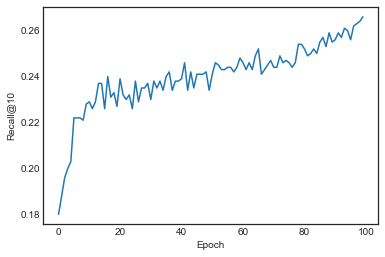

In [7]:
best_path = analysis.get_best_logdir()
dfs = analysis.fetch_trial_dataframes()

plt.plot(dfs[best_path]['recall_at_k']);
plt.xlabel("Epoch")
plt.ylabel("Recall@10");

Below, we can examine all the metadata associated with this trial. 

In [8]:
dfs[best_path].head()

,recall_at_k,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,trial_id
0,0.180,44.850735,False,NaN,NaN,1,43293b235c084f969140c170da6646af,2021-04-22_01-03-56,1619071436,44.850735,16513,mbeck-MBP15-21423.local,192.168.50.246,44.850735,0,1,8c189_00369
1,0.188,31.995902,False,NaN,NaN,2,43293b235c084f969140c170da6646af,2021-04-22_01-04-28,1619071468,76.846637,16513,mbeck-MBP15-21423.local,192.168.50.246,76.846637,0,2,8c189_00369
2,0.196,33.159104,False,NaN,NaN,3,43293b235c084f969140c170da6646af,2021-04-22_01-05-02,1619071502,110.005741,16513,mbeck-MBP15-21423.local,192.168.50.246,110.005741,0,3,8c189_00369
3,0.200,31.929175,False,NaN,NaN,4,43293b235c084f969140c170da6646af,2021-04-22_01-05-34,1619071534,141.934916,16513,mbeck-MBP15-21423.local,192.168.50.246,141.934916,0,4,8c189_00369
4,0.203,32.364741,False,NaN,NaN,5,43293b235c084f969140c170da6646af,2021-04-22_01-06-06,1619071566,174.299657,16513,mbeck-MBP15-21423.local,192.168.50.246,174.299657,0,5,8c189_00369


### Explore the results of the full hyperparameter sweep

Next, we're going to look at how the Recall@10 score changes as a function of various hyperparameter configurations that we tuned over. We tuned over three hyperparameters: the context window size, negative sampling exponent, and the number of negative samples. (Refer to the report for more details.)

We want to look at the Recall@10 scores for all of these configurations but this is a 3-dimensional space and, as such, will be difficult to visualize. Instead, we'll "collapse" one dimension, while examining the other two. To do this, we aggregate the Recall@10 scores (taking the mean) along the "collapsed" dimension.

In [9]:
def aggregate_z(x_name, y_name):
    grouped = results.groupby([f"config/{x_name}", f"config/{y_name}"])
    x_values = []
    y_values = []
    mean_recall_values = []
    
    for name, grp in grouped:
        x_values.append(name[0])
        y_values.append(name[1])
        mean_recall_values.append(grp['recall_at_k'].mean())
    return x_values, y_values, mean_recall_values

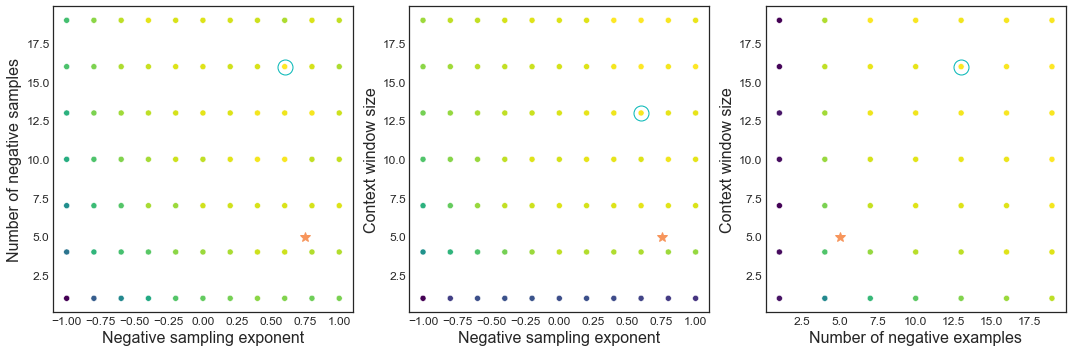

In [11]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(131)
negative, ns_exp, recall = aggregate_z("negative", "ns_exponent")
cm = sns.scatterplot(x=ns_exp, y=negative, hue=recall, palette=color_palette, legend=None)
ax.set_xlabel("Negative sampling exponent", fontsize=16)
ax.set_ylabel("Number of negative samples", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.plot(0.75, 5, 
         marker='*', 
         color=cldr_colors[1],
         markersize=10)
ax.plot(best_config['ns_exponent'], 
        best_config['negative'], 
         marker="o", 
         fillstyle='none', 
         color=cldr_colors[0],
         markersize=15)
ax = fig.add_subplot(132)

window, ns_exp, recall = aggregate_z("window", "ns_exponent")
cm = sns.scatterplot(x=ns_exp, y=window, hue=recall, palette=color_palette, legend=None)
ax.set_xlabel("Negative sampling exponent", fontsize=16)
ax.set_ylabel("Context window size", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.plot(0.75, 5, 
           marker='*', 
           color=cldr_colors[1],
           markersize=10)
ax.plot(best_config['ns_exponent'], 
         best_config['window'], 
         marker="o", 
         fillstyle='none', 
         color=cldr_colors[0],
         markersize=15)

ax = fig.add_subplot(133)
window, negative, recall = aggregate_z("window", "negative")
cm = sns.scatterplot(x=window, y=negative, hue=recall, palette=color_palette, legend=None)
ax.set_xlabel("Number of negative examples", fontsize=16)
ax.set_ylabel("Context window size", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.plot(5, 5, 
        marker='*',
        color=cldr_colors[1],
        markersize=10)
ax.plot(best_config['window'], 
         best_config['negative'], 
         marker="o", 
         fillstyle='none', 
         color=cldr_colors[0],
         markersize=15);

plt.tight_layout()
#plt.savefig("../docs/images/hpsweep_results.png", transparent=True, dpi=150)

And there we have it! Each panel shows the Recall@10 scores (where yellow is a high score and purple is a low score) associated with a unique configuration of hyperparameters. The best hyperparameter values for the Online Retail Data Set are denoted by the light blue circle. Word2vec’s default values are shown by the orange star. In all cases, the orange star is nowhere near the light blue circle, indicating that the default values are not optimal for this dataset.